Now, do these:
1. Send a signal with headers and packets
2. Then estimate the channel on the header, estimate x on the packet
3. Using this new x, estimate the channel on this packet and get a new channel value
4. Use this to estimate the next packet 

In [51]:
pip install mpmath

Note: you may need to restart the kernel to use updated packages.


In [52]:
import mpmath as mp
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
from scipy.special import j0

In [81]:
# Set the precision (number of decimal digits)
mp.dps = 34  # Equivalent to approximately double-double precision

# Signal and channel parameters
Fs = mp.mpf('100000')    # Sampling frequency
Fc = mp.mpf('2e9')       # Carrier frequency
Fd = mp.mpf('100')       # Doppler frequency
Tc = mp.mpf('1') / (mp.mpf('10') * Fd)  # Coherence time based on Doppler frequency
N = 2000000               # Increase number of data points for better statistics
packet_size = int(mp.floor(Fs * Tc))    # Size of each packet
header_packet_size = int(mp.floor((mp.mpf('1') / mp.mpf('6')) * packet_size))  # Header size
epsilon = mp.mpf('1e-10')  # Small constant to avoid division by zero


In [83]:
def generate_bpsk_signal(N):
    bits = np.random.randint(0, 2, N)
    return np.array([mp.mpf(2 * int(bit) - 1) for bit in bits])


def sum_of_sines_model(N, Fd, Fs):
    t = np.array([mp.mpf(n) / Fs for n in range(N)])
    num_sines = 8  # Number of sinusoids
    doppler_shifts = [Fd * mp.cos(2 * mp.pi * mp.mpf(k) / (2 * num_sines + 1)) for k in range(1, num_sines + 1)]
    phases = [mp.mpf(np.random.uniform(0, 2 * np.pi)) for _ in range(num_sines)]
    channel = np.array([mp.mpc('0') for _ in range(N)])
    
    for i in range(num_sines):
        for n in range(N):
            exponent = 1j * (2 * mp.pi * doppler_shifts[i] * t[n] + phases[i])
            channel[n] += mp.exp(exponent)
    
    channel = channel / mp.sqrt(num_sines)  # Normalize power
    return channel


def add_noise(signal, snr_db):
    snr_linear = mp.power(10, snr_db / mp.mpf('10'))
    signal_power = mp.mpf(np.mean([mp.fabs(s)**2 for s in signal]))
    noise_power = signal_power / snr_linear
    noise_std = mp.sqrt(noise_power / mp.mpf('2'))
    noise = np.array([noise_std * (mp.mpf(float(np.random.randn())) + 1j * mp.mpf(float(np.random.randn()))) for _ in signal])
    return signal + noise


In [85]:
def compute_ber(original_bits, estimated_bits):
    errors = sum(1 for o, e in zip(original_bits, estimated_bits) if o != e)
    return mp.mpf(errors) / mp.mpf(len(original_bits))


# BPSK demodulation
def bpsk_demodulate(signal):
    return np.array([mp.mpf(1) if mp.re(s) >= mp.mpf('0') else mp.mpf(-1) for s in signal])

In [87]:
# Main function to calculate BER and MSE
def calculate_ber_mse(N, Fs, packet_size, header_packet_size, snr_db_range, doppler_freq_range):
    signal = generate_bpsk_signal(N)  # Generate BPSK signal
    num_packets = N // packet_size     # Number of packets

    # Arrays to store results
    ber_snr = []
    mse_snr = []
    ber_doppler = []
    mse_doppler = []

    # BER and MSE vs SNR
    Fd_fixed = mp.mpf('100')  # Fixed Doppler frequency for SNR analysis
    for snr_db in snr_db_range:
        total_ber = mp.mpf('0')
        total_mse = mp.mpf('0')
        total_bits = 0
        total_header_bits = 0

        for packet_idx in range(num_packets):
            # Generate a constant channel for this packet
            channel = sum_of_sines_model(1, Fd_fixed, Fs)[0]
            packet_channel = np.array([channel] * packet_size)

            # Get the current packet of signal
            packet_start = packet_idx * packet_size
            packet_end = packet_start + packet_size
            packet_signal = signal[packet_start:packet_end]

            # Transmit signal through channel
            transmitted_signal = packet_signal * packet_channel

            # Add noise
            noisy_signal = add_noise(transmitted_signal, snr_db)

            # Known header parts
            header_transmitted = packet_signal[:header_packet_size]
            header_noisy = noisy_signal[:header_packet_size]

            # Perform least squares estimation to estimate the channel
            A = np.array([[ht] for ht in header_transmitted], dtype=object)
            b = np.array(header_noisy, dtype=object)
            channel_estimated, residuals, rank, s = lstsq(A.astype(np.complex128), b.astype(np.complex128))
            channel_estimated = mp.mpc(channel_estimated[0])

            # Equalization for the entire packet
            equalized_signal = noisy_signal / channel_estimated

            # BPSK demodulation
            demodulated_signal = bpsk_demodulate(equalized_signal)

            # Compute BER for the packet (excluding header)
            original_bits = packet_signal[header_packet_size:]
            estimated_bits = demodulated_signal[header_packet_size:]
            ber = compute_ber(original_bits, estimated_bits)

            # Compute MSE for the header
            true_channel = packet_channel[:header_packet_size]
            estimated_channel = np.array([channel_estimated] * header_packet_size)
            mse = mp.mpf(np.mean([mp.fabs(tc - ec)**2 for tc, ec in zip(true_channel, estimated_channel)]))

            # Update total counts
            total_ber += ber * len(original_bits)
            total_mse += mse * header_packet_size
            total_bits += len(original_bits)
            total_header_bits += header_packet_size

        # Store average BER and MSE for this SNR
        ber_snr.append(total_ber / total_bits)
        mse_snr.append(total_mse / total_header_bits)

    # BER and MSE vs Doppler Frequency
    snr_db_fixed = mp.mpf('10')  # Fixed SNR for Doppler analysis
    for Fd in doppler_freq_range:
        total_ber = mp.mpf('0')
        total_mse = mp.mpf('0')
        total_bits = 0
        total_header_bits = 0

        for packet_idx in range(num_packets):
            # Generate a constant channel for this packet
            channel = sum_of_sines_model(1, Fd, Fs)[0]
            packet_channel = np.array([channel] * packet_size)

            # Get the current packet of signal
            packet_start = packet_idx * packet_size
            packet_end = packet_start + packet_size
            packet_signal = signal[packet_start:packet_end]

            # Transmit signal through channel
            transmitted_signal = packet_signal * packet_channel

            # Add noise
            noisy_signal = add_noise(transmitted_signal, snr_db_fixed)

            # Known header parts
            header_transmitted = packet_signal[:header_packet_size]
            header_noisy = noisy_signal[:header_packet_size]

            # Perform least squares estimation to estimate the channel
            A = np.array([[ht] for ht in header_transmitted], dtype=object)
            b = np.array(header_noisy, dtype=object)
            channel_estimated, residuals, rank, s = lstsq(A.astype(np.complex128), b.astype(np.complex128))
            channel_estimated = mp.mpc(channel_estimated[0])

            # Equalization for the entire packet
            equalized_signal = noisy_signal / channel_estimated

            # BPSK demodulation
            demodulated_signal = bpsk_demodulate(equalized_signal)

            # Compute BER for the packet (excluding header)
            original_bits = packet_signal[header_packet_size:]
            estimated_bits = demodulated_signal[header_packet_size:]
            ber = compute_ber(original_bits, estimated_bits)

            # Compute MSE for the header
            true_channel = packet_channel[:header_packet_size]
            estimated_channel = np.array([channel_estimated] * header_packet_size)
            mse = mp.mpf(np.mean([mp.fabs(tc - ec)**2 for tc, ec in zip(true_channel, estimated_channel)]))

            # Update total counts
            total_ber += ber * len(original_bits)
            total_mse += mse * header_packet_size
            total_bits += len(original_bits)
            total_header_bits += header_packet_size

        # Store average BER and MSE for this Doppler frequency
        ber_doppler.append(total_ber / total_bits)
        mse_doppler.append(total_mse / total_header_bits)

    return ber_snr, mse_snr, ber_doppler, mse_doppler

In [89]:
# Define SNR and Doppler frequency ranges
snr_db_range = [mp.mpf(snr) for snr in range(-4, 15, 2)]
 # From -5 dB to 13 dB in steps of 2 dB
doppler_freq_range = [mp.mpf(fd) for fd in range(10, 310, 20)]  # From 10 Hz to 90 Hz in steps of 20 Hz

# Call the function to get BER and MSE values
ber_snr, mse_snr, ber_doppler, mse_doppler = calculate_ber_mse(
    N=N,
    Fs=Fs,
    packet_size=packet_size,
    header_packet_size=header_packet_size,
    snr_db_range=snr_db_range,
    doppler_freq_range=doppler_freq_range
)

# Print BER and MSE at 10 dB SNR
snr_10db_index = snr_db_range.index(mp.mpf('10'))
ber_at_10db = ber_snr[snr_10db_index]
mse_at_10db = mse_snr[snr_10db_index]

print(f"BER at 10 dB SNR: {ber_at_10db}")
print(f"MSE at 10 dB SNR: {mse_at_10db}")


BER at 10 dB SNR: 2.97619047619048e-6
MSE at 10 dB SNR: 0.00630193254728324


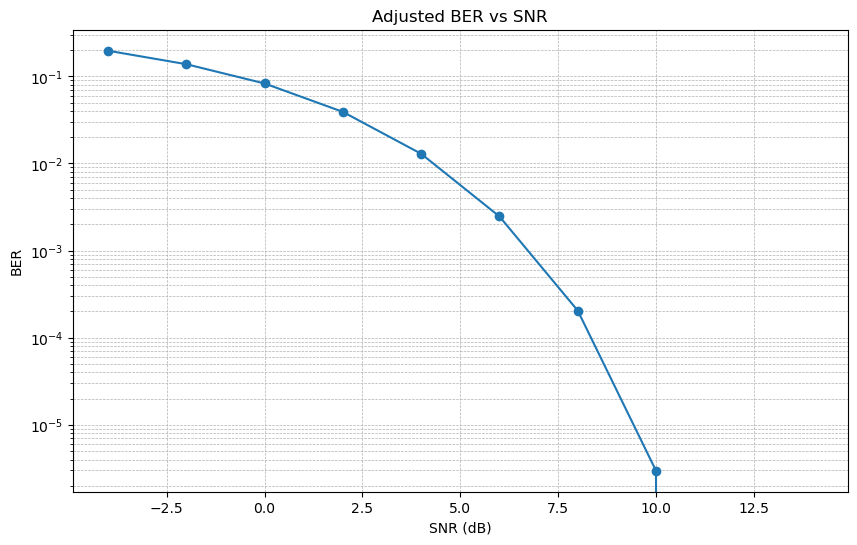

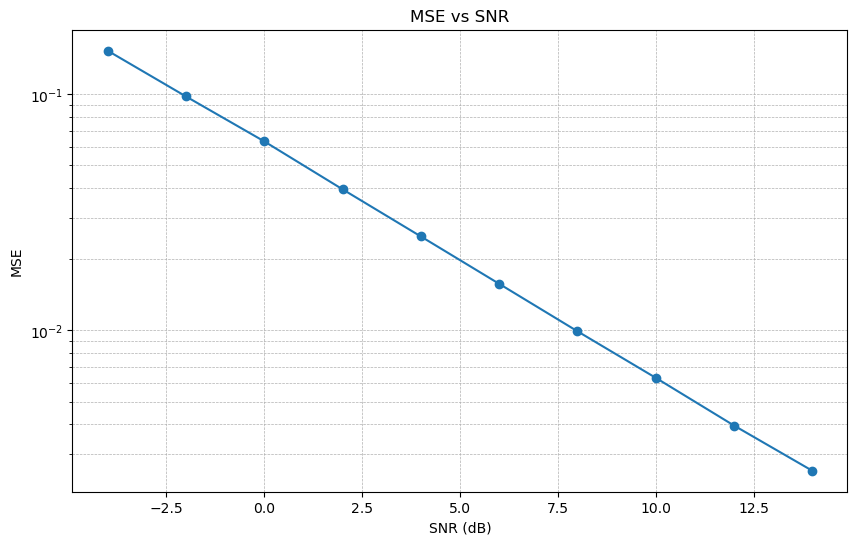

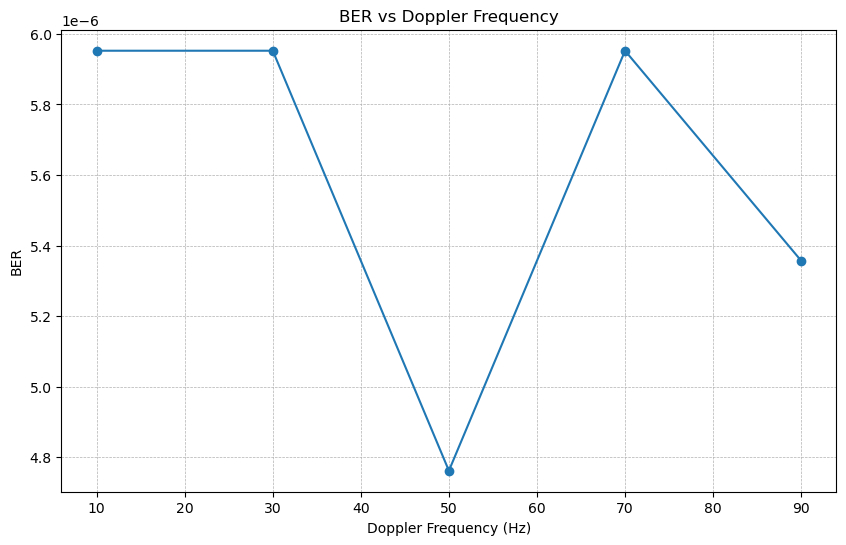

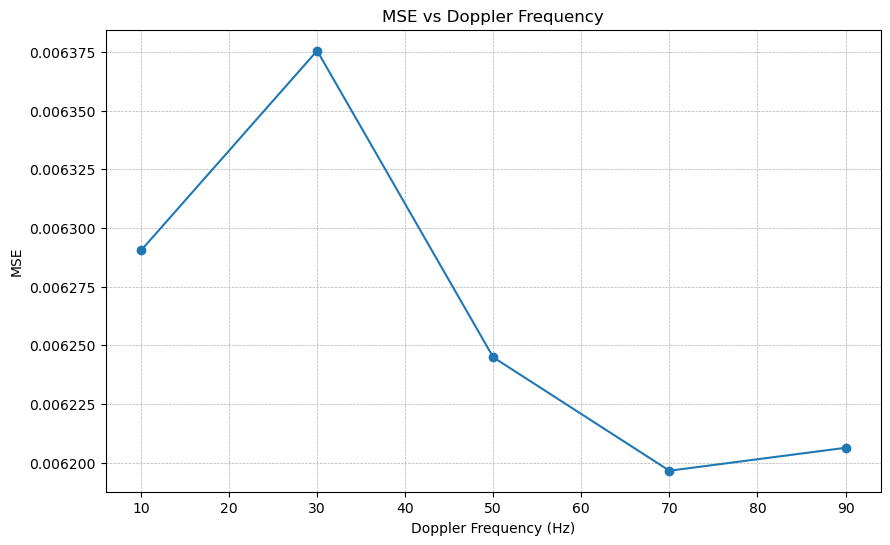

In [90]:
# Convert results to float for plotting
ber_snr_float = [float(ber) for ber in ber_snr]
mse_snr_float = [float(mse) for mse in mse_snr]
ber_doppler_float = [float(ber) for ber in ber_doppler]
mse_doppler_float = [float(mse) for mse in mse_doppler]
snr_db_range_float = [float(snr) for snr in snr_db_range]
doppler_freq_range_float = [float(fd) for fd in doppler_freq_range]

# Plot Adjusted BER vs SNR
plt.figure(figsize=(10, 6))
plt.semilogy(snr_db_range_float, ber_snr_float, marker='o')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('Adjusted BER vs SNR')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=12))
plt.show()

# Plot MSE vs SNR
plt.figure(figsize=(10, 6))
plt.semilogy(snr_db_range_float, mse_snr_float, marker='o')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.title('MSE vs SNR')
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=12))
plt.show()

# Plot BER vs Doppler Frequency
plt.figure(figsize=(10, 6))
plt.plot(doppler_freq_range_float, ber_doppler_float, marker='o')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('BER')
plt.title('BER vs Doppler Frequency')
plt.show()

# Plot MSE vs Doppler Frequency
plt.figure(figsize=(10, 6))
plt.plot(doppler_freq_range_float, mse_doppler_float, marker='o')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xlabel('Doppler Frequency (Hz)')
plt.ylabel('MSE')
plt.title('MSE vs Doppler Frequency')
plt.show()


In [ ]:
# Autocorrelation of the Channel
# Generate a long channel sequence
N_channel = 1000000  # Number of samples for the channel
Fd_autocorr = mp.mpf('100')   # Doppler frequency for autocorrelation
Fs_autocorr = mp.mpf('100000')  # Sampling frequency
channel_sequence = sum_of_sines_model(N_channel, Fd_autocorr, Fs_autocorr)

# Compute autocorrelation
channel_sequence_complex = np.array([complex(c.real, c.imag) for c in channel_sequence])
lags = np.arange(-N_channel + 1, N_channel)
autocorr = np.correlate(channel_sequence_complex, channel_sequence_complex, mode='full')
autocorr = autocorr / np.max(np.abs(autocorr))  # Normalize

# Theoretical autocorrelation
t = lags / float(Fs_autocorr)
theoretical_autocorr = j0(2 * np.pi * float(Fd_autocorr) * np.abs(t))

# Plotting the autocorrelation
plt.figure(figsize=(10, 6))
plt.plot(t, np.real(autocorr), label='Simulated Autocorrelation')
plt.plot(t, theoretical_autocorr, linestyle='--', label='Theoretical J0 Bessel Function')
plt.xlim(-0.01, 0.01)  # Adjust x-axis limits for better visualization
plt.xlabel('Time Lag (s)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of the Rayleigh Fading Channel')
plt.legend()
plt.grid(True)
plt.show()